## Different Graph

In [27]:
from qiskit_optimization.algorithms.qrao import (
    QuantumRandomAccessEncoding,
    SemideterministicRounding,
    QuantumRandomAccessOptimizer,
)
import networkx as nx

from qiskit_optimization.applications import Maxcut

Problem name: Max-cut

Maximize
  -2*x_0*x_4 - 2*x_0*x_6 - 2*x_0*x_8 - 2*x_1*x_2 - 2*x_1*x_6 - 2*x_1*x_7
  - 2*x_2*x_6 - 2*x_2*x_8 - 2*x_3*x_4 - 2*x_3*x_5 - 2*x_3*x_9 - 2*x_4*x_8
  - 2*x_5*x_7 - 2*x_5*x_9 - 2*x_7*x_9 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5 + 3*x_6 + 3*x_7 + 3*x_8 + 3*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9



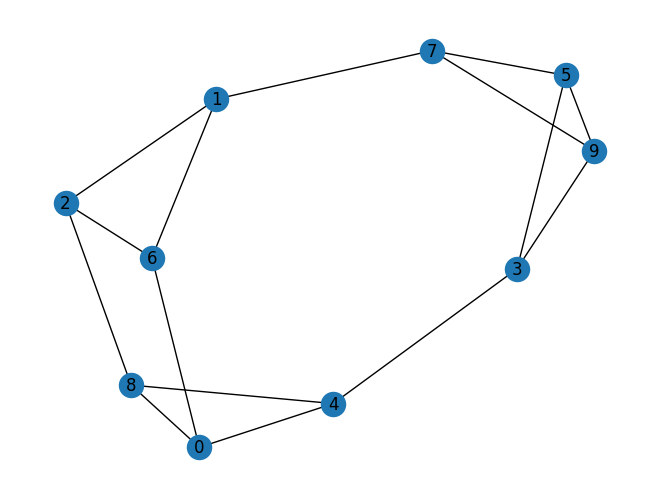

In [28]:
from qiskit_optimization.algorithms.qrao import EncodingCommutationVerifier

seed = 1
num_nodes = 10
graph = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph, seed=seed))

maxcut = Maxcut(graph)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

In [29]:
from qiskit_optimization.algorithms.qrao import QuantumRandomAccessEncoding


# Create an encoding object with a maximum of 3 variables per qubit, aka a (3,1,p)-QRAC
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)

# Encode the QUBO problem into an encoded Hamiltonian
encoding.encode(problem)

# This is our encoded Hamiltonian
print(f"Our encoded Hamiltonian is:\n( {encoding.qubit_op} ).\n")
print(
    "We achieve a compression ratio of "
    f"({encoding.num_vars} binary variables : {encoding.num_qubits} qubits) "
    f"≈ {encoding.compression_ratio}.\n"
)

Our encoded Hamiltonian is:
( SparsePauliOp(['XYII', 'XIXI', 'XIZI', 'YXII', 'YIXI', 'YIYI', 'IXXI', 'IXZI', 'ZYII', 'ZZII', 'ZIIX', 'IYZI', 'IZYI', 'IZIX', 'IIYX'],
              coeffs=[1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j,
 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j]) ).

We achieve a compression ratio of (10 binary variables : 4 qubits) ≈ 2.5.



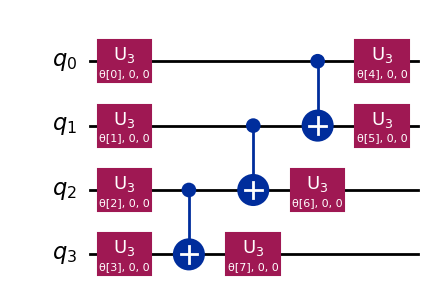

In [30]:
from qiskit.circuit.library import RealAmplitudes
from qiskit import transpile
ansatz = RealAmplitudes(4,reps=1)

ansatz.decompose(reps=3).draw(output='mpl',style='iqp')

## Looking for a Cut

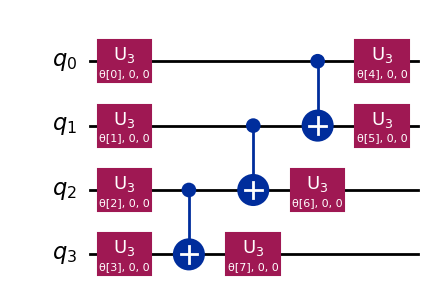

In [31]:
circuit_basis = transpile(ansatz, basis_gates=['u3', 'cx'], optimization_level=3)
circuit_basis.draw(output="mpl", style="iqp",fold=-1)

In [33]:
import numpy as np
from circuit_knitting.cutting.cut_finding.circuit_interface import SimpleGateList
from circuit_knitting.cutting.cut_finding.lo_cuts_optimizer import LOCutsOptimizer
from circuit_knitting.cutting.cut_finding.optimization_settings import (
    OptimizationSettings,
)
from circuit_knitting.cutting.cut_finding.quantum_device_constraints import (
    DeviceConstraints,
)
from circuit_knitting.cutting import partition_problem
from circuit_knitting.cutting.cut_finding.cco_utils import qc_to_cco_circuit
circuit_ckt = qc_to_cco_circuit(circuit_basis)

In [35]:
settings = OptimizationSettings(rand_seed=12345)

settings.set_engine_selection("CutOptimization", "BestFirst")


qubits_per_QPU = 3
num_QPUs = 3


for num_qpus in range(num_QPUs, 1, -1):
    for qpu_qubits in range(qubits_per_QPU, 1, -1):
        print(f"\n\n---------- {qpu_qubits} Qubits per QPU, {num_qpus} QPUs ----------")

        constraint_obj = DeviceConstraints(qubits_per_QPU=qpu_qubits, num_QPUs=num_QPUs)

        interface = SimpleGateList(circuit_ckt)

        op = LOCutsOptimizer(interface, settings, constraint_obj)

        out = op.optimize()

        print(
            " Gamma =",
            None if (out is None) else out.upper_bound_gamma(),
            ", Min_gamma_reached =",
            op.minimum_reached(),
        )
        if out is not None:
            out.print(simple=True)
        else:
            print(out)

        print(
            "Subcircuits:",
            interface.export_subcircuits_as_string(name_mapping="default"),
            "\n",
        )



---------- 3 Qubits per QPU, 3 QPUs ----------
 Gamma = 3.0 , Min_gamma_reached = True
[CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=6, gate_name='cx'))]
Subcircuits: ABBB 



---------- 2 Qubits per QPU, 3 QPUs ----------
 Gamma = 3.0 , Min_gamma_reached = True
[CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=5, gate_name='cx'))]
Subcircuits: AABB 



---------- 3 Qubits per QPU, 2 QPUs ----------
 Gamma = 3.0 , Min_gamma_reached = True
[CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=6, gate_name='cx'))]
Subcircuits: ABBB 



---------- 2 Qubits per QPU, 2 QPUs ----------
 Gamma = 3.0 , Min_gamma_reached = True
[CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=5, gate_name='cx'))]
Subcircuits: AABB 

